In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load dataset
data = pd.read_csv('customers.csv')
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [4]:
# Drop ID column as it's not useful for classification
data = data.drop(columns=["ID"])

In [5]:
# Handle missing values
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)

In [6]:
# Encode categorical variables
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [7]:
# Encode target variable
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])  # A, B, C, D -> 0, 1, 2, 3

In [8]:
# Split features and target
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [12]:
# @title
# Define Neural Network(Model1)
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 4)






    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [13]:
# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs):
  model.train()
  for epoch in range(epochs):
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()




    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [14]:
# Initialize model
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [15]:
train_model(model, train_loader, criterion, optimizer, epochs=100)

Epoch [10/100], Loss: 1.2547
Epoch [20/100], Loss: 1.1244
Epoch [30/100], Loss: 1.0763
Epoch [40/100], Loss: 0.9651
Epoch [50/100], Loss: 1.4424
Epoch [60/100], Loss: 0.9558
Epoch [70/100], Loss: 1.1952
Epoch [80/100], Loss: 0.4689
Epoch [90/100], Loss: 0.5700
Epoch [100/100], Loss: 0.9415


In [16]:
# Evaluation
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [17]:
# Compute metrics
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])
print("Name: LAKSHMIDHAR N")
print("Register No: 212224230138")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name: LAKSHMIDHAR N
Register No: 212224230138
Test Accuracy: 0.45%
Confusion Matrix:
 [[204 101 110 169]
 [147 123 126  94]
 [ 97  86 234  55]
 [104  41  51 397]]
Classification Report:
               precision    recall  f1-score   support

           A       0.37      0.35      0.36       584
           B       0.35      0.25      0.29       490
           C       0.45      0.50      0.47       472
           D       0.56      0.67      0.61       593

    accuracy                           0.45      2139
   macro avg       0.43      0.44      0.43      2139
weighted avg       0.43      0.45      0.44      2139



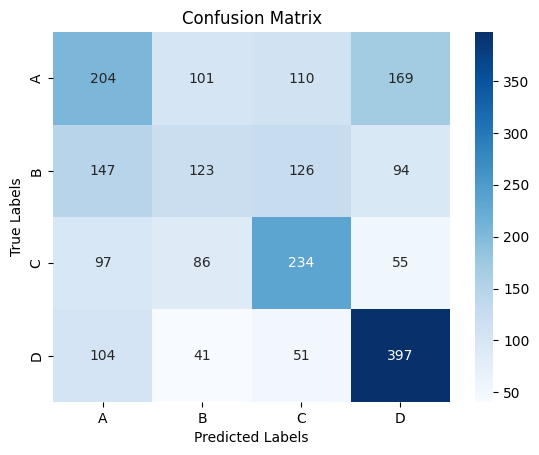

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Prediction for a sample input
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    # Select the prediction for the sample (first element)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name: LAKSHMIDHAR N")
print("Register No: 212224230138")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

Name: LAKSHMIDHAR N
Register No: 212224230138
Predicted class for sample input: D
Actual class for sample input: D
